In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate

data_dir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission/PODAAC-metadata/'

adir_sbe='F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-'


# Metadata
- SBE56 info, set some attributes and depths for metadata
- put filenames and depts into a xarray dataset


In [5]:

vattrs = {'long_name': 'sea surface depth',
          'standard_name': 'sea_water_temperature', 'installed_height':'-0.295 m' ,
          'serial_number' : 'SBE05608196', 'model_number': '56', 
          'sensor_description': 'Seabird 56 Temperature Logger',
          'model_name': 'SBE 56', 'product_page':'http://www.seabird.com/sbe56-temperature-logger', 
          'nominal_sampling_schedule': '2 sec', 
          'units':'degrees_C','valid_min':-10.0,'valid_max':50.0}

tattrs = {'_FillValue':np.nan,
          'long_name':'time',
          'standard_name':'time',
          'coverage_content_type':'coordinate',
          'axis':'T'}

astr_sbe36=['SBE05609153_2019-11-25.csv','SBE05609154_2019-11-25.csv',
         'SBE05609158_2019-11-25.csv','SBE05609150_2019-11-25.csv',
         'SBE05609151_2019-11-25.csv','SBE05609152_2019-11-25.csv',
           'SBE05609157_2019-11-25.csv']

depth36=[330,473,823,1048,1209,1436,1700]

astr_sbe37=['SBE05608196_2019-11-25.csv','SBE05604705_2019-11-25.csv',
         'SBE05605200_2019-11-25.csv','SBE05608476_2019-11-25.csv',
         'SBE05609159_2019-11-25.csv','SBE05609155_2019-11-26.csv',
         'SBE05609156_2019-11-26.csv']
depth37=[324,474,805,1035,1196,1413,1725]

adepth=[depth36,depth37]
astr = [astr_sbe36,astr_sbe37]

ds_info = xr.Dataset(data_vars={'fname':(['trajectory','z'],astr),
                                'depth':(['trajectory','z'],adepth)},
                     coords={'z':np.arange(7),'trajectory':[1036,1037]})




# Combine the .cvs files into a single netcdf file with metadata

- for sbe3 on 1036, it fell off, so i put nan for that one
- for several 1037 they stopped at different dates so i filled with nan at end to make same length

In [107]:
del ds_sbe
iobs_start=0
for iusv in range(0,2): #2
    if iusv==0:
        fname='saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680.nc'
        fname_out='saildrone-gen_5-arctic_misst_2019-SBE56-sd1036-20190514T230000-20191011T183000-v1.nc'
    if iusv==1:
        fname='saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc'
        fname_out='saildrone-gen_5-arctic_misst_2019-SBE56-sd1037-20190514T230000-20191011T183000-v1.nc'
    ds = xr.open_dataset(data_dir+fname)
    ds.close()
    gattrs=ds.attrs   
    for iz in range(7): #7
        fstr = str(ds_info.fname[iusv,iz].data)
        avehicle=str(ds_info.trajectory[iusv].data)
        filename=adir_sbe+avehicle+'/'+fstr
        print(filename)
        if (iusv==0) and (iz==3):  #the third sbe56 fell off & file doesn't exist
            vname2='sea_water_temperature_'+str(iz).zfill(2)
            xf=xf.rename({vname:vname2})
            xf[vname2]=xf[vname2]*np.nan
            vname='sea_water_temperature_'+str(iz).zfill(2)
            vattrs['installed_height']=str(-1*ds_info.depth[iusv,iz].data/1000.)+' m'
            vattrs['serial_number']=fstr[:11]
            xf.attrs=vattrs
        else:
            df = pd.read_csv(filename,header=11) #, sheet_name='data')
            df['time']=pd.to_datetime(df['Date'] + ' ' + df['Time']) 
            del df['Date']
            del df['Time']
            df.index=df['time']
            xf=df.to_xarray()
            if iusv==0:
                xf['time']=xf.time+np.timedelta64(8,'h')
            xf = xf.sel(time=slice('2019-05-14T23:00:00','2019-10-11T18:30:00'))
            print(xf.time[0].data)
            vname='sea_water_temperature_'+str(iz).zfill(2)
            xf=xf.rename({'Temperature':vname})
            vattrs['installed_height']=str(-1*ds_info.depth[iusv,iz].data/1000.)+' m'
            vattrs['serial_number']=fstr[:11]
            xf.attrs=vattrs
        print(iusv,iz,xf.time.min().data,xf.time.max().data)
        if iz==0:
            nobs_start=xf.time.size
        iobs=np.arange(xf.time.size)
        nobs=xf.time.size
        if nobs_start>nobs:
            xf_save = xf_save.rename({vname_save:vname})
            xf = xr.concat([xf.sel(time=slice(xf.time[0],xf.time[-2])),xf_save.sel(time=slice(xf.time[-1],xf_save.time[-1]))*np.nan],dim='time')
        if iz==0:
            td=np.ones((1,xf.time.size))*np.nan
            td[0,:]=xf[vname]
            ds_sbe=xr.Dataset(data_vars={vname:
                                         (['trajectory','obs'],td)},
                  coords={'trajectory':[avehicle]})
            ds_sbe[vname].attrs=vattrs
        else:
            td=np.ones((1,xf.time.size))*np.nan
            ds_sbe2=xr.Dataset(data_vars={vname:
                                         (['trajectory','obs'],td)},
                  coords={'trajectory':[avehicle]})
            ds_sbe2[vname][0,:]=xf[vname].data
            ds_sbe2[vname].attrs=vattrs
            ds_sbe = xr.merge([ds_sbe,ds_sbe2])
        xf_save=xf
        vname_save=vname
    #at saildrone there was an error setting the cloud 
    #on the first set of SBE to local rather than GMT time
    td=np.zeros((1,xf.time.size), dtype='datetime64[s]')
    td[0,:]=xf.time.data
    tem=xr.Dataset(data_vars={'time':
                                 (['trajectory','obs'],td)},
          coords={'trajectory':[avehicle]})
    ds_sbe = xr.merge([ds_sbe,tem])
#    if iusv==0:
#        ds_sbe['time']=ds_sbe.time+np.timedelta64(8,'h')
    ds_sbe=ds_sbe.assign_coords(time=ds_sbe.time)
    gattrs['time_coverage_resolution']='PT2S'
    gattrs['uuid']=str(uuid.uuid4())
    gattrs['keywords']='Temperature, Saildrone, Arctic, Berring Sea, Chukchi Sea, NASA, NOAA'
    gattrs['history']='created post-cruise by Gentemann 3/2/2020'  
    ds_sbe.attrs=gattrs
    fout=data_dir+fname_out
    ds_sbe['trajectory']=ds.trajectory
    
#add lat and lon
    flat = interpolate.interp1d(ds.time[0,:].astype('float64'),ds.latitude[0,:])
    newlat = flat(ds_sbe.time[0,:].astype('float64'))
    flon = interpolate.interp1d(ds.time[0,:].astype('float64'),ds.longitude[0,:])
    newlon = flon(ds_sbe.time[0,:].astype('float64'))
    td=np.zeros((1,xf.time.size), dtype='double')
    td[0,:]=newlat
    tem=xr.Dataset(data_vars={'latitude':
                                 (['trajectory','obs'],td)},
          coords={'trajectory':[avehicle]})
    ds_sbe = xr.merge([ds_sbe,tem])
    ds_sbe=ds_sbe.assign_coords(latitude=ds_sbe.latitude)
    td=np.zeros((1,xf.time.size), dtype='double')
    td[0,:]=newlon
    tem=xr.Dataset(data_vars={'longitude':
                                 (['trajectory','obs'],td)},
          coords={'trajectory':[avehicle]})
    ds_sbe = xr.merge([ds_sbe,tem])
    ds_sbe=ds_sbe.assign_coords(longitude=ds_sbe.longitude)

#output data
    ds_sbe.to_netcdf(fout)
#    del ds_sbe


F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609153_2019-11-25.csv
2019-05-14T23:00:04.000000000
0 0 2019-05-14T23:00:04.000000000 2019-10-11T18:29:59.000000000
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609154_2019-11-25.csv
2019-05-14T23:00:04.000000000
0 1 2019-05-14T23:00:04.000000000 2019-10-11T18:29:59.000000000
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609158_2019-11-25.csv
2019-05-14T23:00:04.000000000
0 2 2019-05-14T23:00:04.000000000 2019-10-11T18:29:59.000000000
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609150_2019-11-25.csv
0 3 2019-05-14T23:00:04.000000000 2019-10-11T18:29:59.000000000
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609151_2019-11-25.csv
2019-05-14T23:00:04.000000000
0 4 2019-05-14T23:00:04.000000000 2019-10-11T18:29:59.000000000
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609152_2019-11-25.csv
2019-05-14T23:00:04.000000000
0 5 2019-05-14T23:00:04.00000000

In [ ]:
print('sb_xfe time',xf.time.min().data)
print('sbe time',ds_sbe.time.min().data)
print('usv time',ds.time.min().data)
print('max')
print('sbe time',ds_sbe.time.max().data)
print('usv time',ds.time.max().data)

In [108]:
ds_sbe

<xarray.Dataset>
Dimensions:                   (obs: 2588760, trajectory: 1)
Coordinates:
  * trajectory                (trajectory) object '1037'
    time                      (trajectory, obs) datetime64[ns] 2019-05-14T23:00:04 ... 2019-10-11T18:29:59
    latitude                  (trajectory, obs) float64 53.85 53.85 ... 53.84
    longitude                 (trajectory, obs) float64 -166.6 -166.6 ... -166.6
Dimensions without coordinates: obs
Data variables:
    sea_water_temperature_00  (trajectory, obs) float64 7.114 7.114 ... 9.013
    sea_water_temperature_01  (trajectory, obs) float64 7.11 7.112 ... nan nan
    sea_water_temperature_02  (trajectory, obs) float64 7.102 7.106 ... 9.04
    sea_water_temperature_03  (trajectory, obs) float64 7.098 7.094 ... 9.054
    sea_water_temperature_04  (trajectory, obs) float64 6.736 6.737 ... 9.88
    sea_water_temperature_05  (trajectory, obs) float64 6.736 6.742 ... 10.24
    sea_water_temperature_06  (trajectory, obs) float64 6.743 6.744 ... 9.904

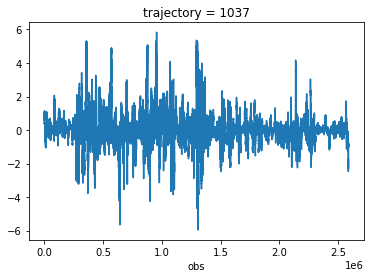

In [116]:
rdif=(ds_sbe.sea_water_temperature_00-ds_sbe.sea_water_temperature_06)
rdif.plot(label='00')
#ds_sbe.sea_water_temperature_01.plot()